In [ ]:
%%bash
rm -rf tabpfn-extensions
git clone https://github.com/PriorLabs/tabpfn-extensions.git
cd tabpfn-extensions
pip install -e .

Obtaining file:///content/tabpfn-extensions
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.

Cloning into 'tabpfn-extensions'...


<ipython-input-3-b15cec0fee6f>:58: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time', limit_direction='forward')
/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:101: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(


Visualizando as primeiras linhas após pré-processamento:
                     conc_silica  param_dosagem_amido  \
inicio                                                  
2024-02-01 03:00:00         2.89           493.100006   
2024-02-01 05:00:00         2.61           494.040009   
2024-02-02 07:00:00         4.43           496.570007   
2024-02-02 13:00:00         2.27           492.829987   
2024-02-02 15:00:00         1.68           496.010010   

                     dosagem_amina_conc_magnetica  ph_flotacao_linha01  \
inicio                                                                   
2024-02-01 03:00:00                    142.289993                 9.55   
2024-02-01 05:00:00                    143.750000                 9.49   
2024-02-02 07:00:00                    168.899994                 9.57   
2024-02-02 13:00:00                    137.070007                 9.52   
2024-02-02 15:00:00                    146.910004                 9.50   

                     ph_

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN => MSE: 3.4262 | RMSE: 1.8510 | R²: -0.0001 | MAPE: 95.74% | Tempo de treino: 2.50s | q_hat = 3.18
Coverage (esperado ~95%): 0.925

=== RandomForest ===
RandomForest => MSE: 4.0810 | RMSE: 2.0201 | R²: -0.1913 | MAPE: 105.92% | Tempo de treino: 0.46s | q_hat = 3.73
Coverage (esperado ~95%): 0.933

=== XGB ===
XGB => MSE: 4.7710 | RMSE: 2.1843 | R²: -0.3927 | MAPE: 112.60% | Tempo de treino: 0.23s | q_hat = 4.06
Coverage (esperado ~95%): 0.937


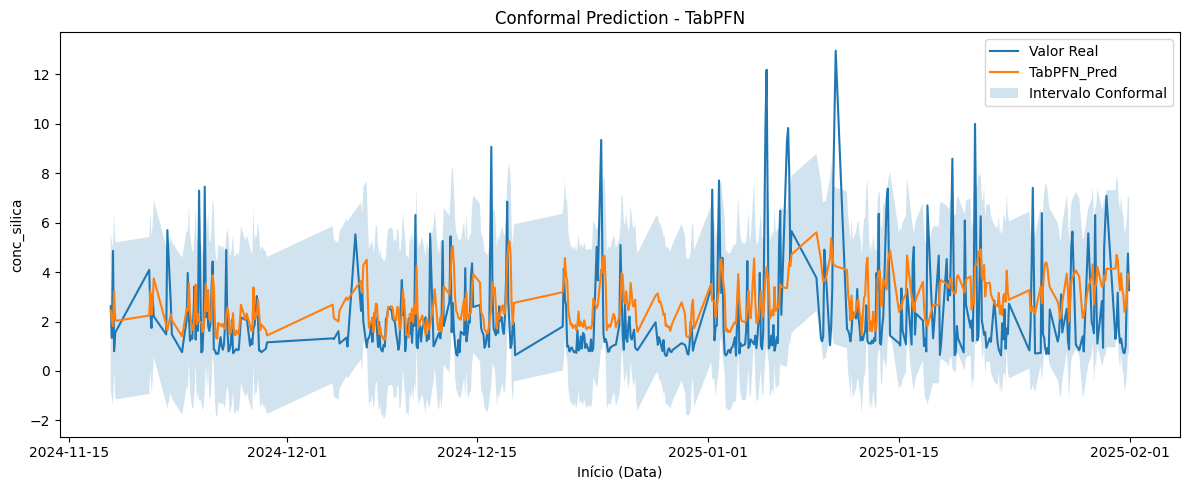

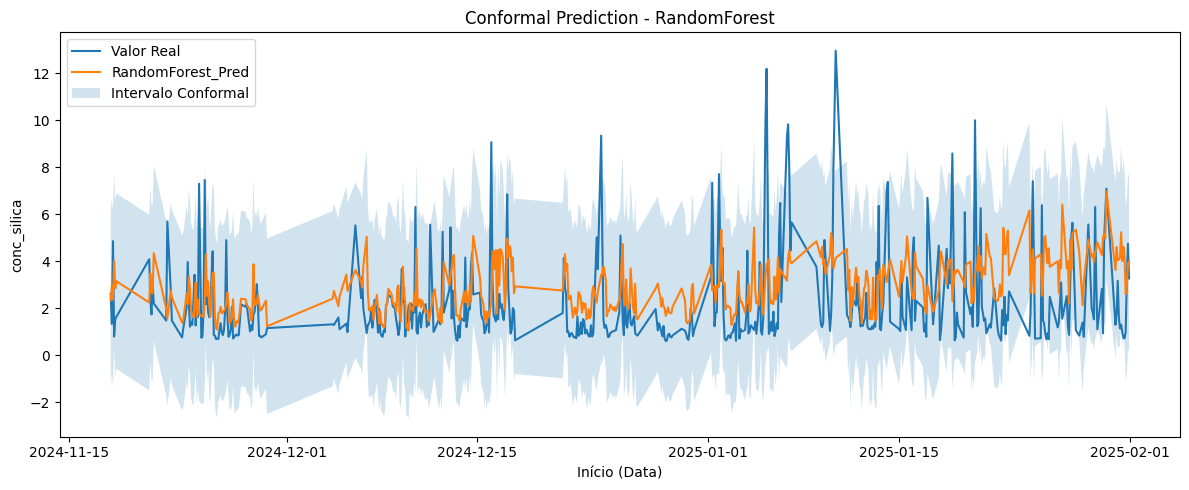

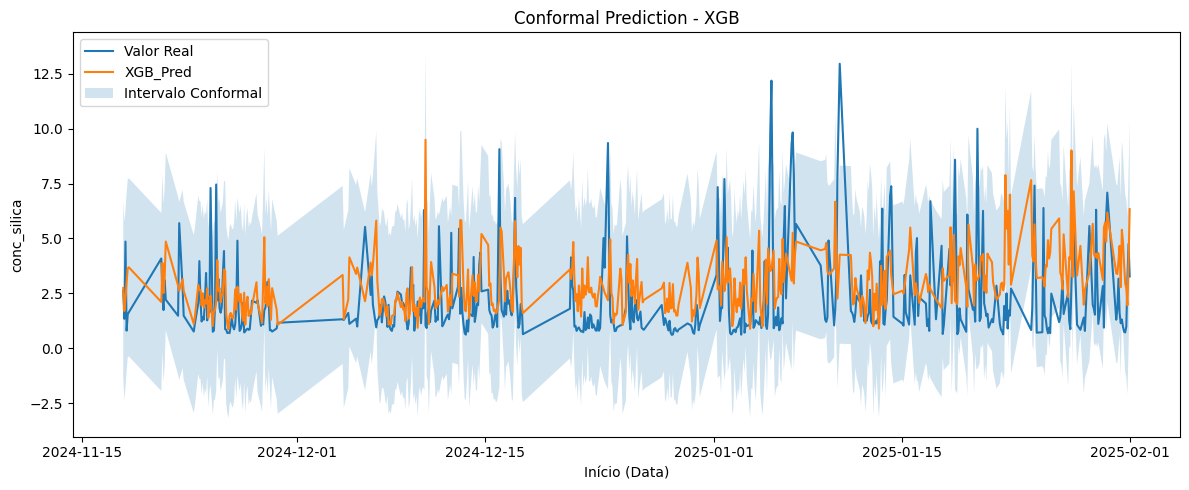

Resultados do TabPFN salvos em: flotacao_dados_dentro_do_padrao_predictions_TabPFN.csv
Resultados do RandomForest salvos em: flotacao_dados_dentro_do_padrao_predictions_RandomForest.csv
Resultados do XGB salvos em: flotacao_dados_dentro_do_padrao_predictions_XGB.csv

Pipeline concluído com sucesso!


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Se estiver usando TabPFN:
# pip install tabpfn
from tabpfn import TabPFNRegressor

# Modelos
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import os

###############################################################################
# Atualize o caminho para o seu arquivo:
# flotacao_dados_IQR
caminho_csv = "flotacao_dados_dentro_do_padrao.csv"

nome_arquivo = os.path.splitext(os.path.basename(caminho_csv))[0]
df = pd.read_csv(caminho_csv, sep=';', low_memory=True)

# Converter a coluna 'inicio' para datetime; ajuste o formato se necessário.
df['inicio'] = pd.to_datetime(df['inicio'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# Definir 'inicio' como índice do DataFrame
df.set_index('inicio', inplace=True)

###############################################################################
# 2) Remover colunas indesejadas: remover 'fim' e "conc_fe" (se existirem)
###############################################################################
df.drop(columns=['fim', "conc_fe"], errors='ignore', inplace=True)

###############################################################################
# 3) Tratar strings indesejadas e conversão das colunas numéricas
###############################################################################
df = df.replace(',', '.', regex=True)
df.replace('[-11059] No Good Data For Calculation', np.nan, inplace=True)

# Converter as colunas que podem ser convertidas para numérico e gravá-las em colunas_numericas
colunas_numericas = []
for col in df.columns:
    try:
        pd.to_numeric(df[col], errors='raise')
        colunas_numericas.append(col)
    except:
        pass

df[colunas_numericas] = df[colunas_numericas].astype(np.float32)

###############################################################################
# 4) Interpolar valores ausentes com base no índice temporal e ordenar o DataFrame
###############################################################################
df = df.interpolate(method='time', limit_direction='forward')
df.sort_index(inplace=True)
df = df.dropna()

print("Visualizando as primeiras linhas após pré-processamento:")
print(df.head(), "\n")

###############################################################################
# 5) Definir a coluna-alvo e separar X e y
###############################################################################
# Ajuste o nome da coluna-alvo conforme mostrado no DataFrame; neste caso, usamos 'conc_silica'
target_col = 'conc_silica'
if target_col not in df.columns:
    raise ValueError(f"A coluna-alvo '{target_col}' não existe no DataFrame.")

# Diferenças
# df['diff_1s']  = df[target_col].diff(periods=1)
# df['diff_2']  = df[target_col].diff(periods=2)
# df['diff_4'] = df[target_col].diff(periods=4)

# # # Lags
# df['lag_5s']  = df[target_col].shift(5)
# df['lag_10s'] = df[target_col].shift(10)
# df['lag_30s'] = df[target_col].shift(30)
# df['lag_60s'] = df[target_col].shift(60)

# Haverá NaNs gerados pelas janelas/lags, então removemos linhas com NaN
df.dropna(inplace=True)
# Cria X removendo a coluna alvo e, em seguida, seleciona apenas as colunas numéricas para evitar erro no scaling
X = df.drop(columns=[target_col], errors='ignore')
X = X.select_dtypes(include=np.number)  # Mantém apenas colunas numéricas
y = df[target_col]

###############################################################################
# 6) Separar dados em Treino e Teste
###############################################################################
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print("Tamanhos (antes do scaling):")
print(" X_train_full:", X_train_full.shape, "| y_train_full:", y_train_full.shape)
print(" X_test:", X_test.shape, "          | y_test:", y_test.shape)

###############################################################################
# 7) Padronizar (StandardScaler) as colunas numéricas de X
###############################################################################
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

###############################################################################
# 8) Função de Inductive Conformal Prediction
###############################################################################
def inductive_conformal_prediction(model, X_train_prop, y_train_prop, X_cal, y_cal, X_test, alpha=0.05):
    """
    Treina o modelo em (X_train_prop, y_train_prop).
    Usa (X_cal, y_cal) para calibrar o erro.
    Retorna y_pred_test, lower, upper, q_hat e o tempo de treinamento.
    """
    start_time = time.time()
    model.fit(X_train_prop, y_train_prop)
    training_time = time.time() - start_time

    # Previsões no conjunto de calibração
    y_cal_pred = model.predict(X_cal)
    cal_errors = np.abs(y_cal - y_cal_pred)
    n_cal = len(y_cal)

    # Cálculo do quantil para a cobertura (1 - alpha)
    alpha_adj = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
    q_hat = np.quantile(cal_errors, alpha_adj)

    # Previsões no conjunto de teste
    y_pred_test = model.predict(X_test)
    lower = y_pred_test - q_hat
    upper = y_pred_test + q_hat

    return y_pred_test, lower, upper, q_hat, training_time

###############################################################################
# 9) Separar parte do treino para calibração (10% dos dados de treino)
###############################################################################
X_train_prop, X_cal, y_train_prop, y_cal = train_test_split(
    X_train_full_scaled, y_train_full,
    test_size=0.1,  # 10% para calibração
    random_state=42,
    shuffle=False
)

print("\nTamanhos (depois da divisão ProperTrain/Calib):")
print("  Proper Train =", X_train_prop.shape)
print("  Calib        =", X_cal.shape)
print("  Test         =", X_test_scaled.shape)

###############################################################################
# 10) (Opcional) Limitar tamanho de treino para o TabPFN
###############################################################################
def limit_training_size(X_data, y_data, max_size=10000):
    if len(X_data) > max_size:
        return X_data[:max_size], y_data[:max_size]
    else:
        return X_data, y_data

###############################################################################
# 11) Definir e treinar modelos
###############################################################################
models = {
    "TabPFN": TabPFNRegressor(ignore_pretraining_limits=True),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGB": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

alpha = 0.05  # Intervalo de ~95%
results = {}

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    # Se for TabPFN, limite o tamanho do treino se necessário
    if model_name == "TabPFN":
        X_train_prop_used, y_train_prop_used = limit_training_size(X_train_prop, y_train_prop)
    else:
        X_train_prop_used, y_train_prop_used = X_train_prop, y_train_prop

    # Executar Conformal Prediction
    y_pred_test, lower_test, upper_test, q_hat, training_time = inductive_conformal_prediction(
        model,
        X_train_prop_used, y_train_prop_used,
        X_cal, y_cal,
        X_test_scaled,
        alpha=alpha
    )

    # Cálculo das métricas
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)
    mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100  # Em porcentagem

    # Exibir resultados
    print(f"{model_name} => MSE: {mse:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f} | "
          f"MAPE: {mape:.2f}% | Tempo de treino: {training_time:.2f}s | q_hat = {q_hat:.2f}")

    # Cálculo da cobertura do intervalo
    within_interval = (y_test >= lower_test) & (y_test <= upper_test)
    coverage = within_interval.mean()
    print(f"Coverage (esperado ~95%): {coverage:.3f}")

    # Armazenar os resultados em um DataFrame
    df_res = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred_test,
        'lower': lower_test,
        'upper': upper_test
    }, index=y_test.index)

    results[model_name] = df_res

###############################################################################
# 12) Plotar os resultados
###############################################################################
for model_name, df_res in results.items():
    plt.figure(figsize=(12, 5))
    plt.plot(df_res.index, df_res['actual'], label='Valor Real')
    plt.plot(df_res.index, df_res['predicted'], label=f'{model_name}_Pred')
    plt.fill_between(
        df_res.index,
        df_res['lower'],
        df_res['upper'],
        alpha=0.2,
        label='Intervalo Conformal'
    )
    plt.xlabel('Início (Data)')
    plt.ylabel(target_col)
    plt.title(f'Conformal Prediction - {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

###############################################################################
# 13) (Opcional) Salvar previsões em CSV
###############################################################################
for model_name, df_res in results.items():
    csv_name = f"{nome_arquivo}_predictions_{model_name}.csv"
    df_res.to_csv(csv_name)
    print(f"Resultados do {model_name} salvos em: {csv_name}")

print("\nPipeline concluído com sucesso!")


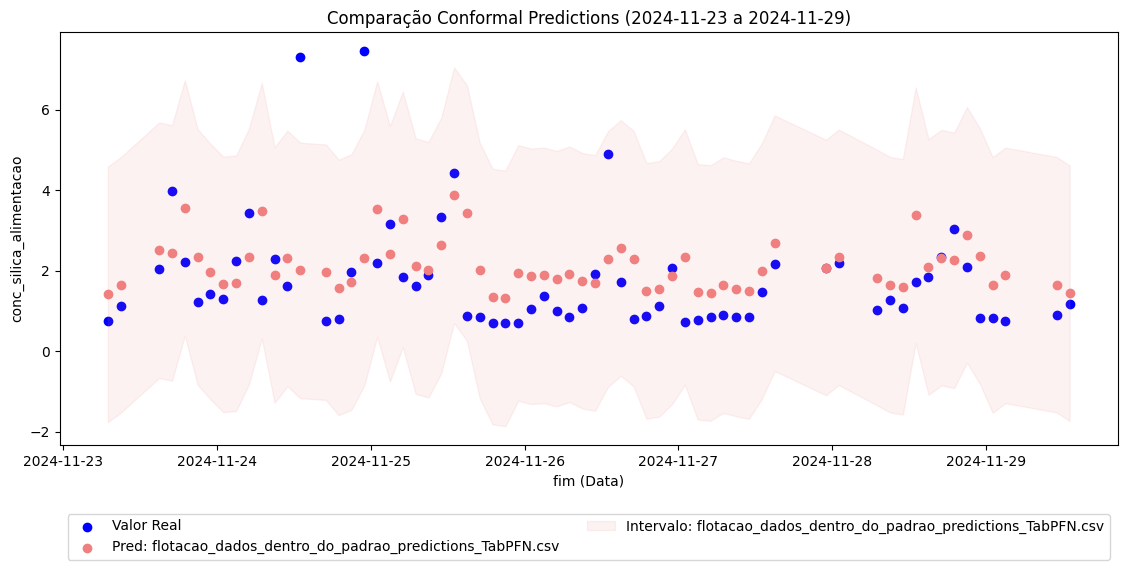

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_conformal_predictions(
    file_list,
    color_list,
    start_date,
    end_date
):
    """
    Lê diversos arquivos CSV de predições conformais, filtra por data
    e plota em um único gráfico.

    Parâmetros
    ----------
    file_list : list of str
        Lista de caminhos (strings) dos arquivos CSV.
        Cada CSV deve conter colunas: ['actual', 'predicted', 'lower', 'upper']
        e o índice (não nomeado) na primeira coluna (datas).
        Exemplo de salvamento anterior: df_res.to_csv("predictions_XYZ.csv")
    color_list : list of str
        Lista de cores correspondentes a cada arquivo.
        Ex.: ['red', 'green', 'orange'].
    start_date : str
        Data inicial no formato 'YYYY-MM-DD' (ou outro compatível com pandas).
    end_date : str
        Data final no formato 'YYYY-MM-DD'.

    Retorno
    -------
    None (gera e mostra o gráfico)
    """

    if len(file_list) != len(color_list):
        raise ValueError("A quantidade de arquivos deve bater com a quantidade de cores.")

    # Lê o primeiro CSV para extrair 'actual' e plotá-lo como referência
    df_first = pd.read_csv(
        file_list[0],
        parse_dates=[0],  # Usa a primeira coluna (sem nome) como datas
        index_col=0       # Usa a primeira coluna como índice
    )

    # Filtra pelo intervalo de datas [start_date, end_date]
    df_first = df_first.loc[start_date:end_date].sort_index()

    # Inicia a figura
    plt.figure(figsize=(12, 6))

    # Plot dos valores reais (bolinhas azuis) usando o primeiro CSV como referência
    plt.scatter(
        df_first.index,
        df_first['actual'],
        label='Valor Real',
        color='blue',
        marker='o'
    )

    # Plot das predições/intervalos do primeiro arquivo
    plt.scatter(
        df_first.index,
        df_first['predicted'],
        label=f'Pred: {file_list[0]}',
        color=color_list[0],
        marker='o'
    )
    plt.fill_between(
        df_first.index,
        df_first['lower'],
        df_first['upper'],
        color=color_list[0],
        alpha=0.1,
        label=f'Intervalo: {file_list[0]}'
    )

    # Para os demais arquivos, ler e plotar da mesma forma
    for i in range(1, len(file_list)):
        csv_file = file_list[i]
        df_temp = pd.read_csv(
            csv_file,
            parse_dates=[0],
            index_col=0
        )
        df_temp = df_temp.loc[start_date:end_date].sort_index()

        # Plot das predições (bolinhas)
        plt.scatter(
            df_temp.index,
            df_temp['predicted'],
            label=f'Pred: {csv_file}',
            color=color_list[i],
            marker='o'
        )
        # Plot do intervalo conformal
        plt.fill_between(
            df_temp.index,
            df_temp['lower'],
            df_temp['upper'],
            color=color_list[i],
            alpha=0.1,
            label=f'Intervalo: {csv_file}'
        )

    # Ajustes de eixos e título
    plt.xlabel('fim (Data)')
    plt.ylabel('conc_silica_alimentacao')
    plt.title(f'Comparação Conformal Predictions ({start_date} a {end_date})')

    # Legenda abaixo do gráfico
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,  # número de colunas da legenda — ajuste conforme quantidade de entradas
        fontsize=10,
        frameon=True
    )

    # Ajustar layout para caber a legenda fora
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)  # espaço extra abaixo para a legenda
    plt.show()



if __name__ == "__main__":
    # Lista de arquivos da imagem
    file_list = [
        # "flotacao_dados_IQR_predictions_TabPFN.csv",
        # "flotacao_dados_IQR_predictions_XGB.csv",
        # "flotacao_dados_IQR_predictions_RandomForest.csv",
        "flotacao_dados_dentro_do_padrao_predictions_TabPFN.csv",
        # "flotacao_dados_dentro_do_padrao_predictions_XGB.csv",
        # "flotacao_dados_dentro_do_padrao_predictions_RandomForest.csv",
    ]

    # Cores associadas a cada modelo (ex: vermelho p/ TabPFN, verde p/ XGB, laranja p/ RandomForest)
    # IQR -> tons mais escuros, dentro_do_padrao -> tons mais claros
    color_list = [
        # "darkred",    # IQR - TabPFN
        # "darkgreen",  # IQR - XGB
        # "darkorange", # IQR - RandomForest
        "lightcoral", # dentro_do_padrao - TabPFN
        # "lightgreen", # dentro_do_padrao - XGB
        # "gold",       # dentro_do_padrao - RandomForest
    ]

    # Intervalo de datas desejado
    start_date = "2024-11-23"
    end_date = "2024-11-29"

    # Chamada da função
    plot_conformal_predictions(file_list, color_list, start_date, end_date)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -------------------------------
# MÉTRICAS GLOBAIS POR MODELO
# -------------------------------
def print_global_metrics(file_list, model_names, mape_threshold=None):
    print("\n📊 Métricas globais por modelo:\n")
    for file, model in zip(file_list, model_names):
        try:
            df = pd.read_csv(file)
            df["MAPE"] = np.abs((df["actual"] - df["predicted"]) / df["actual"]) * 100

            # Filtro opcional por MAPE
            if mape_threshold is not None:
                df = df[df["MAPE"] < mape_threshold]

            # Se, após o filtro, não restar nada:
            if df.empty:
                print(f"{model}: Dados insuficientes após filtro.")
                continue

            r2 = r2_score(df["actual"], df["predicted"])
            mape = df["MAPE"].mean()
            rmse = np.sqrt(mean_squared_error(df["actual"], df["predicted"]))
            mae = mean_absolute_error(df["actual"], df["predicted"])

            print(f"{model}:")
            print(f"  R²   = {r2:.4f}")
            print(f"  MAPE = {mape:.2f}%")
            print(f"  RMSE = {rmse:.4f}")
            print(f"  MAE  = {mae:.4f}\n")

        except Exception as e:
            print(f"{model}: Erro ao processar — {e}")

# -------------------------------
# MÉTRICAS POR BIN DE SÍLICA
# -------------------------------
def compute_metrics_by_silica(file_list, model_names, bins=30, mape_threshold=None):
    all_data = []

    for file, model_name in zip(file_list, model_names):
        df = pd.read_csv(file)
        df["MAPE"] = np.abs((df["actual"] - df["predicted"]) / df["actual"]) * 100

        # Filtro opcional por MAPE
        if mape_threshold is not None:
            df = df[df["MAPE"] < mape_threshold]

        if df.empty:
            print(f"[⚠️] {model_name} — Dados vazios após filtro. Ignorando.")
            continue

        df["squared_error"] = (df["actual"] - df["predicted"]) ** 2
        df["abs_error"] = np.abs(df["actual"] - df["predicted"])
        df["modelo"] = model_name
        all_data.append(df)

    if not all_data:
        print("[❌] Nenhum dado válido para calcular métricas.")
        return pd.DataFrame()

    full_df = pd.concat(all_data)
    actual_min = full_df["actual"].min()
    actual_max = full_df["actual"].max()

    if actual_min == actual_max:
        print(f"[❌] Todos os valores de 'actual' são iguais a {actual_min}. Não é possível criar bins.")
        return pd.DataFrame()

    # Cria bins de sílica e adiciona colunas
    silica_bins = np.linspace(actual_min, actual_max, bins)
    full_df["silica_bin"] = pd.cut(full_df["actual"], silica_bins)
    full_df["silica_mid"] = full_df["silica_bin"].apply(lambda x: x.mid)

    metric_list = []
    skipped_bins = 0  # Contador para bins com menos de 2 amostras

    # observed=True evita o FutureWarning e usa apenas categorias existentes
    for (modelo, mid), group in full_df.groupby(["modelo", "silica_mid"], observed=True):
        # Se o grupo tiver menos de 2 amostras, não tem como calcular R²
        if len(group) < 2:
            skipped_bins += 1
            continue

        try:
            r2 = r2_score(group["actual"], group["predicted"])
        except:
            r2 = np.nan

        mape = group["MAPE"].mean()
        rmse = np.sqrt(group["squared_error"].mean())
        mae = group["abs_error"].mean()

        metric_list.append({
            "modelo": modelo,
            "silica_mid": mid,
            "R2": r2,
            "MAPE": mape,
            "RMSE": rmse,
            "MAE": mae
        })

    print(f"[INFO] Bins ignorados (<2 amostras): {skipped_bins}")
    return pd.DataFrame(metric_list)

# -------------------------------
# PLOT DE MÉTRICAS POR BIN
# -------------------------------
def plot_error_metrics(grouped_df, color_list, metrics_to_plot=["R2", "MAPE", "RMSE", "MAE"]):
    if grouped_df.empty:
        print("[⚠️] Nenhuma métrica por bin disponível para plotar.")
        return

    models = grouped_df["modelo"].unique()

    metric_titles = {
        "R2": "R² por faixa de valor real de sílica",
        "MAPE": "MAPE por faixa de valor real de sílica",
        "RMSE": "RMSE por faixa de valor real de sílica",
        "MAE": "MAE por faixa de valor real de sílica"
    }

    metric_ylabels = {
        "R2": "R²",
        "MAPE": "MAPE médio (%)",
        "RMSE": "RMSE médio",
        "MAE": "MAE médio"
    }

    n_metrics = len(metrics_to_plot)
    fig, axs = plt.subplots(n_metrics, 1, figsize=(12, 5 * n_metrics), sharex=True)
    axs = axs if n_metrics > 1 else [axs]

    for i, metric in enumerate(metrics_to_plot):
        for j, model in enumerate(models):
            data = grouped_df[grouped_df["modelo"] == model]
            axs[i].plot(
                data["silica_mid"],
                data[metric],
                label=model,
                color=color_list[j],
                marker='o'
            )

        axs[i].set_ylabel(metric_ylabels[metric])
        axs[i].set_title(metric_titles[metric])
        axs[i].legend()
        axs[i].grid(True)

        # Limite do eixo Y apenas para R²
        if metric == "R2":
            r2_min = grouped_df["R2"].min()
            r2_max = grouped_df["R2"].max()
            # Se quiser remover completamente, é só comentar a linha abaixo
            axs[i].set_ylim(max(-8, r2_min - 0.05), min(r2_max + 0.05, 1.05))

    axs[-1].set_xlabel("Valor real de sílica (binned)")
    plt.tight_layout()
    plt.show()



📊 Métricas globais por modelo:

TabPFN_IQR:
  R²   = 0.2105
  MAPE = 59.40%
  RMSE = 1.1599
  MAE  = 0.8487

XGB_IQR:
  R²   = 0.1064
  MAPE = 63.53%
  RMSE = 1.2340
  MAE  = 0.9393

RandomForest_IQR:
  R²   = 0.0959
  MAPE = 66.53%
  RMSE = 1.2412
  MAE  = 0.9527

TabPFN_padrao:
  R²   = 0.8110
  MAPE = 39.95%
  RMSE = 0.8060
  MAE  = 0.5879

XGB_padrao:
  R²   = 0.7981
  MAPE = 42.94%
  RMSE = 0.8330
  MAE  = 0.6268

RandomForest_padrao:
  R²   = 0.8452
  MAPE = 38.75%
  RMSE = 0.7294
  MAE  = 0.5640

[INFO] Bins ignorados por conter menos de 2 amostras: 0


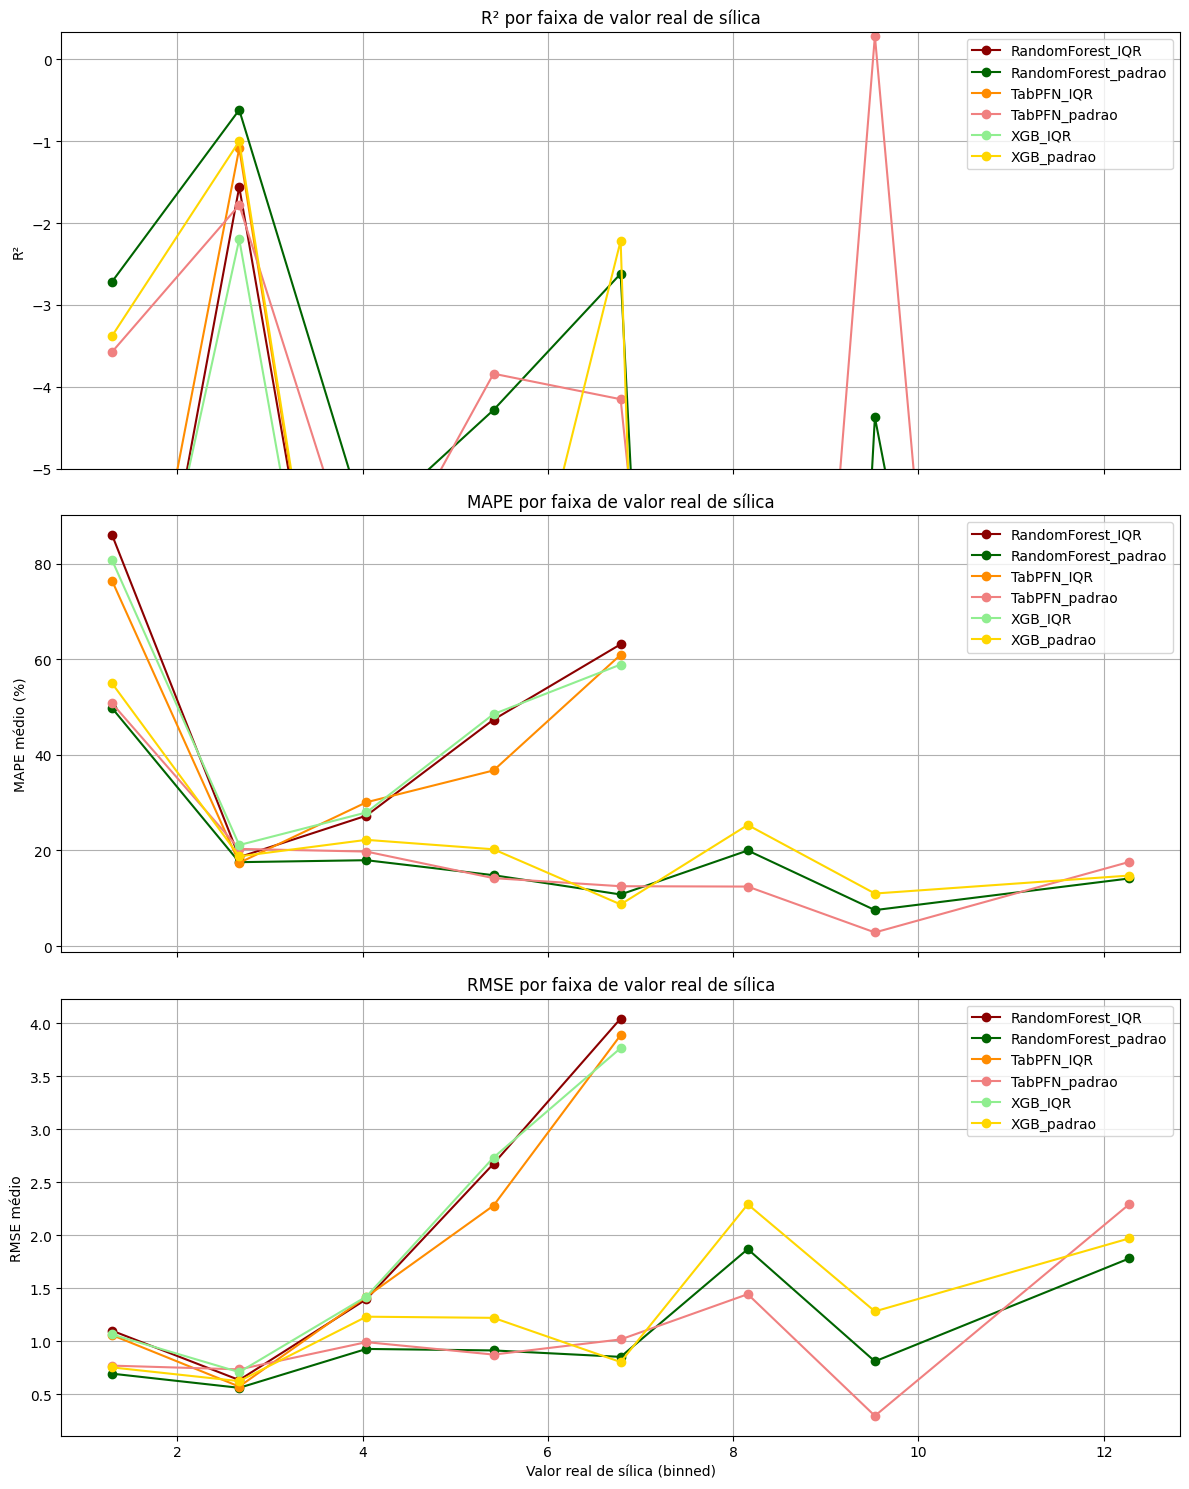

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -------------------------------
# MÉTRICAS GLOBAIS POR MODELO
# -------------------------------
def print_global_metrics(file_list, model_names, mape_threshold=None):
    print("\n📊 Métricas globais por modelo:\n")
    for file, model in zip(file_list, model_names):
        try:
            df = pd.read_csv(file)
            df["MAPE"] = np.abs((df["actual"] - df["predicted"]) / df["actual"]) * 100
            if mape_threshold is not None:
                df = df[df["MAPE"] < mape_threshold]

            if df.empty:
                print(f"{model}: Dados insuficientes após filtro.")
                continue

            r2 = r2_score(df["actual"], df["predicted"])
            mape = df["MAPE"].mean()
            rmse = np.sqrt(mean_squared_error(df["actual"], df["predicted"]))
            mae = mean_absolute_error(df["actual"], df["predicted"])

            print(f"{model}:")
            print(f"  R²   = {r2:.4f}")
            print(f"  MAPE = {mape:.2f}%")
            print(f"  RMSE = {rmse:.4f}")
            print(f"  MAE  = {mae:.4f}\n")

        except Exception as e:
            print(f"{model}: Erro ao processar — {e}")

# -------------------------------
# MÉTRICAS POR BIN DE SÍLICA
# -------------------------------
def compute_metrics_by_silica(file_list, model_names, bins=10, mape_threshold=None):
    """
    Calcula métricas por bin de valor real de sílica (coluna 'actual').
    Skip bins com menos de 2 amostras para evitar R² indefinido.
    """
    all_data = []

    # Lê e concatena dados de todos os arquivos
    for file, model_name in zip(file_list, model_names):
        df = pd.read_csv(file)
        df["MAPE"] = np.abs((df["actual"] - df["predicted"]) / df["actual"]) * 100
        if mape_threshold is not None:
            df = df[df["MAPE"] < mape_threshold]
        if df.empty:
            print(f"[⚠️] {model_name} — Dados vazios após filtro. Ignorando.")
            continue

        df["squared_error"] = (df["actual"] - df["predicted"]) ** 2
        df["abs_error"] = np.abs(df["actual"] - df["predicted"])
        df["modelo"] = model_name
        all_data.append(df)

    if not all_data:
        print("[❌] Nenhum dado válido para calcular métricas.")
        return pd.DataFrame()

    full_df = pd.concat(all_data)
    actual_min = full_df["actual"].min()
    actual_max = full_df["actual"].max()

    if actual_min == actual_max:
        print(f"[❌] Todos os valores de 'actual' são iguais a {actual_min}. Não é possível criar bins.")
        return pd.DataFrame()

    # Cria os bins com numpy.linspace
    silica_bins = np.linspace(actual_min, actual_max, bins)
    full_df["silica_bin"] = pd.cut(full_df["actual"], silica_bins)
    # Pega o valor médio de cada bin pra plot
    full_df["silica_mid"] = full_df["silica_bin"].apply(lambda x: x.mid)

    metric_list = []
    skipped_bins = 0  # Para depurar quantos bins foram ignorados
    # Agrupa por modelo e pelo meio do bin
    for (modelo, mid), group in full_df.groupby(["modelo", "silica_mid"], observed=True):
        # Se o bin tiver menos de 2 pontos, não dá pra calcular R²
        if len(group) < 2:
            skipped_bins += 1
            continue

        # Calcular métricas
        r2 = r2_score(group["actual"], group["predicted"])
        mape = group["MAPE"].mean()
        rmse = np.sqrt(group["squared_error"].mean())
        mae = group["abs_error"].mean()

        metric_list.append({
            "modelo": modelo,
            "silica_mid": mid,
            "R2": r2,
            "MAPE": mape,
            "RMSE": rmse,
            "MAE": mae
        })

    print(f"[INFO] Bins ignorados por conter menos de 2 amostras: {skipped_bins}")

    return pd.DataFrame(metric_list)

# -------------------------------
# PLOT DE MÉTRICAS POR BIN
# -------------------------------
def plot_error_metrics(grouped_df, color_list, metrics_to_plot=["R2", "MAPE", "RMSE", "MAE"]):
    if grouped_df.empty:
        print("[⚠️] Nenhuma métrica por bin disponível para plotar.")
        return

    models = grouped_df["modelo"].unique()

    metric_titles = {
        "R2": "R² por faixa de valor real de sílica",
        "MAPE": "MAPE por faixa de valor real de sílica",
        "RMSE": "RMSE por faixa de valor real de sílica",
        "MAE": "MAE por faixa de valor real de sílica"
    }

    metric_ylabels = {
        "R2": "R²",
        "MAPE": "MAPE médio (%)",
        "RMSE": "RMSE médio",
        "MAE": "MAE médio"
    }

    n_metrics = len(metrics_to_plot)
    fig, axs = plt.subplots(n_metrics, 1, figsize=(12, 5 * n_metrics), sharex=True)
    axs = axs if n_metrics > 1 else [axs]

    for i, metric in enumerate(metrics_to_plot):
        for j, model in enumerate(models):
            data = grouped_df[grouped_df["modelo"] == model]
            axs[i].plot(
                data["silica_mid"], data[metric],
                label=model, color=color_list[j], marker='o'
            )
        axs[i].set_ylabel(metric_ylabels[metric])
        axs[i].set_title(metric_titles[metric])
        axs[i].legend()
        axs[i].grid(True)

        # Aqui, se quiser limitar R² a algo mais amplo (p. ex. [-5, 1.05])
        if metric == "R2":
            r2_min = grouped_df["R2"].min()
            r2_max = grouped_df["R2"].max()
            axs[i].set_ylim(max(-5, r2_min - 0.05), min(r2_max + 0.05, 1.05))

    axs[-1].set_xlabel("Valor real de sílica (binned)")
    plt.tight_layout()
    plt.show()

# -------------------------------
# EXECUÇÃO PRINCIPAL (exemplo)
# -------------------------------
if __name__ == "__main__":
    file_list = [
        "flotacao_dados_IQR_predictions_TabPFN.csv",
        "flotacao_dados_IQR_predictions_XGB.csv",
        "flotacao_dados_IQR_predictions_RandomForest.csv",
        "flotacao_dados_dentro_do_padrao_predictions_TabPFN.csv",
        "flotacao_dados_dentro_do_padrao_predictions_XGB.csv",
        "flotacao_dados_dentro_do_padrao_predictions_RandomForest.csv"
    ]
    # Gera nomes de modelos automaticamente
    model_names = []
    for file in file_list:
        modelo = ""
        dataset = "IQR" if "IQR" in file else "padrao"
        if "TabPFN" in file:
            modelo = "TabPFN"
        elif "XGB" in file:
            modelo = "XGB"
        elif "RandomForest" in file:
            modelo = "RandomForest"
        else:
            modelo = "Outro"
        model_names.append(f"{modelo}_{dataset}")

    # Cores associadas
    color_list = [
        "darkred",    # IQR - TabPFN
        "darkgreen",  # IQR - XGB
        "darkorange", # IQR - RF
        "lightcoral", # padrão - TabPFN
        "lightgreen", # padrão - XGB
        "gold"        # padrão - RF
    ]

    # 1) Métricas globais
    print_global_metrics(file_list, model_names, mape_threshold=None)

    # 2) Métricas por bin de sílica (usa 10 bins, p.ex.)
    grouped_metrics = compute_metrics_by_silica(
        file_list, model_names,
        bins=10,             # experimente reduzir
        mape_threshold=None  # ou ex: 300 para filtrar outliers
    )

    # 3) Plotar (R2, MAPE, RMSE, e se quiser MAE)
    plot_error_metrics(grouped_metrics, color_list, metrics_to_plot=["R2", "MAPE", "RMSE"])
